# 0.0 IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
import datetime

## 0.1 Helper Functions

## 0.2 Loading data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

In [3]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on='Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 DATA DESCRIPTION

## 1.1 Rename Columns

In [4]:
df1 = df_raw.copy()

In [5]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list( map (snakecase, cols_old))

#rename
df1.columns = cols_new

In [7]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [8]:
print(f'Number of rowns df1.shape[0]')
print(f'Número of columns df1.shape[1]')

Number of rowns df1.shape[0]
Número of columns df1.shape[1]


## 1.3 Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [10]:
df1['date']

0         2015-07-31
1         2015-07-31
2         2015-07-31
3         2015-07-31
4         2015-07-31
             ...    
1017204   2013-01-01
1017205   2013-01-01
1017206   2013-01-01
1017207   2013-01-01
1017208   2013-01-01
Name: date, Length: 1017209, dtype: datetime64[ns]

## 1.4 Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fill NA

In [12]:
#competition_distance
# Distância da loja concorrente mais próxima. Por estar em branco, vamos substituir considerando que o valor é igual ao valor mais alto do dataset
df1['competition_distance'] = df1['competition_distance'].fillna(int(200000))

#competition_open_since_month
#Vamos considerar o mês semelhante à coluna Date
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)


#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# #promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

#promo_interval
month_map = {1 :'Jan', 2 :'Feb',3 :'Mar',4 :'Apr',5 :'May',6 :'Jun',7 :'Jul',8 :'Aug',9 :'Sep',10 :'Oct',11 :'Nov',12 :'Dec'}
df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 
    0 if x['promo_interval'] == 0 
    else 
        1 if x['month_map'] in x['promo_interval'].split( ',') 
        else 0, 
        axis=1)


In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [14]:
df1.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 1.6 Change Types

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [18]:
# Split dataset in numerics or categorical columns
num_attributes = df1.select_dtypes(include=['int64','int32','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','int32','float64','datetime64[ns]'])

In [19]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
887790,1036,6,5124,490,1,0,0,9560.0,4,2013,1,36,2013,1
479462,798,1,12100,1314,1,1,0,9560.0,4,2001,0,18,2014,0


In [20]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
958633,0,c,c,"Jan,Apr,Jul,Oct",Feb
720165,0,d,c,0,Sep


In [21]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0


## 1.7.1 Numerical Attributes

In [22]:
# Central Tendency - mean, medians
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew','kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


c:\Users\vinicius.sousa\Desktop\github\DSemProd\venvDSemProd\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

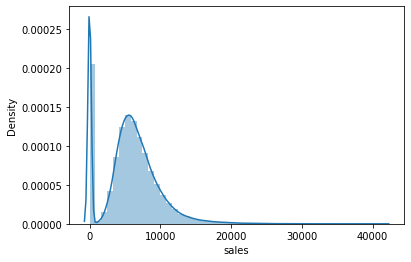

In [23]:
sns.distplot( df1['sales'])

c:\Users\vinicius.sousa\Desktop\github\DSemProd\venvDSemProd\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

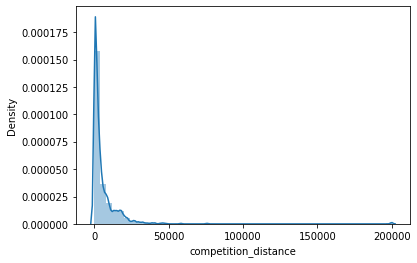

In [24]:
sns.distplot( df1['competition_distance'])

## 1.7.2 Categorical Attributes

In [25]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

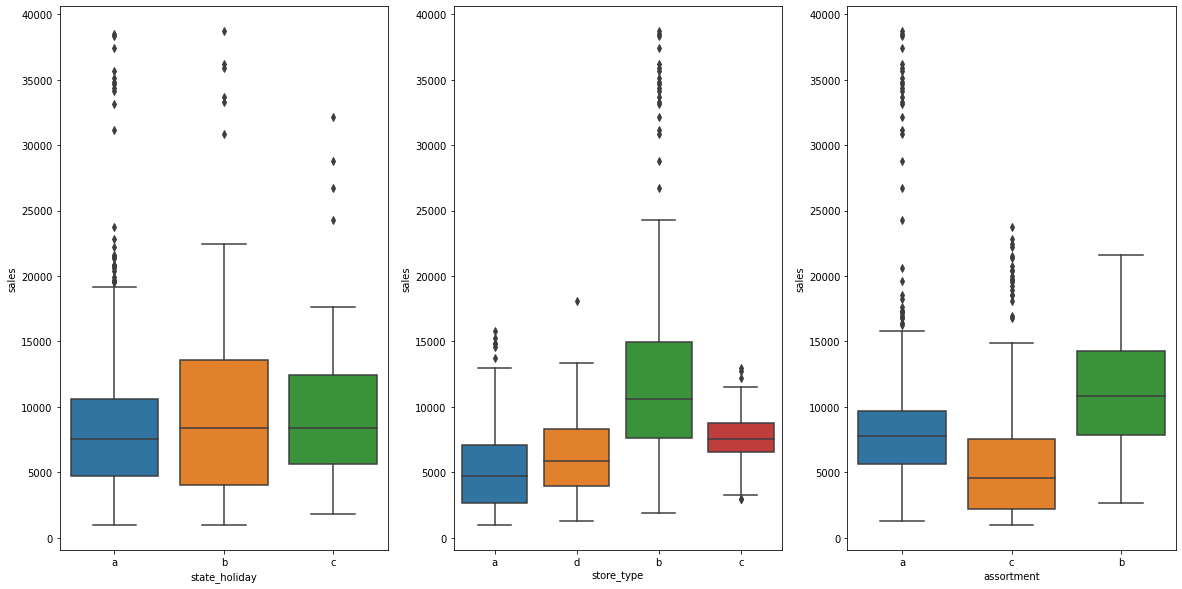

In [26]:
plt.figure(figsize=(20,10))
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1)
sns.boxplot(x= 'state_holiday',y='sales' ,data=aux1)

plt.subplot( 1, 3, 2)
sns.boxplot(x= 'store_type',y='sales' ,data=aux1)

plt.subplot( 1, 3, 3)
sns.boxplot(x= 'assortment',y='sales' ,data=aux1)

# 2.0 FEATURE ENGINEERING

In [27]:
df2 = df1.copy()

## 2.1 Mindmap Hypothesis

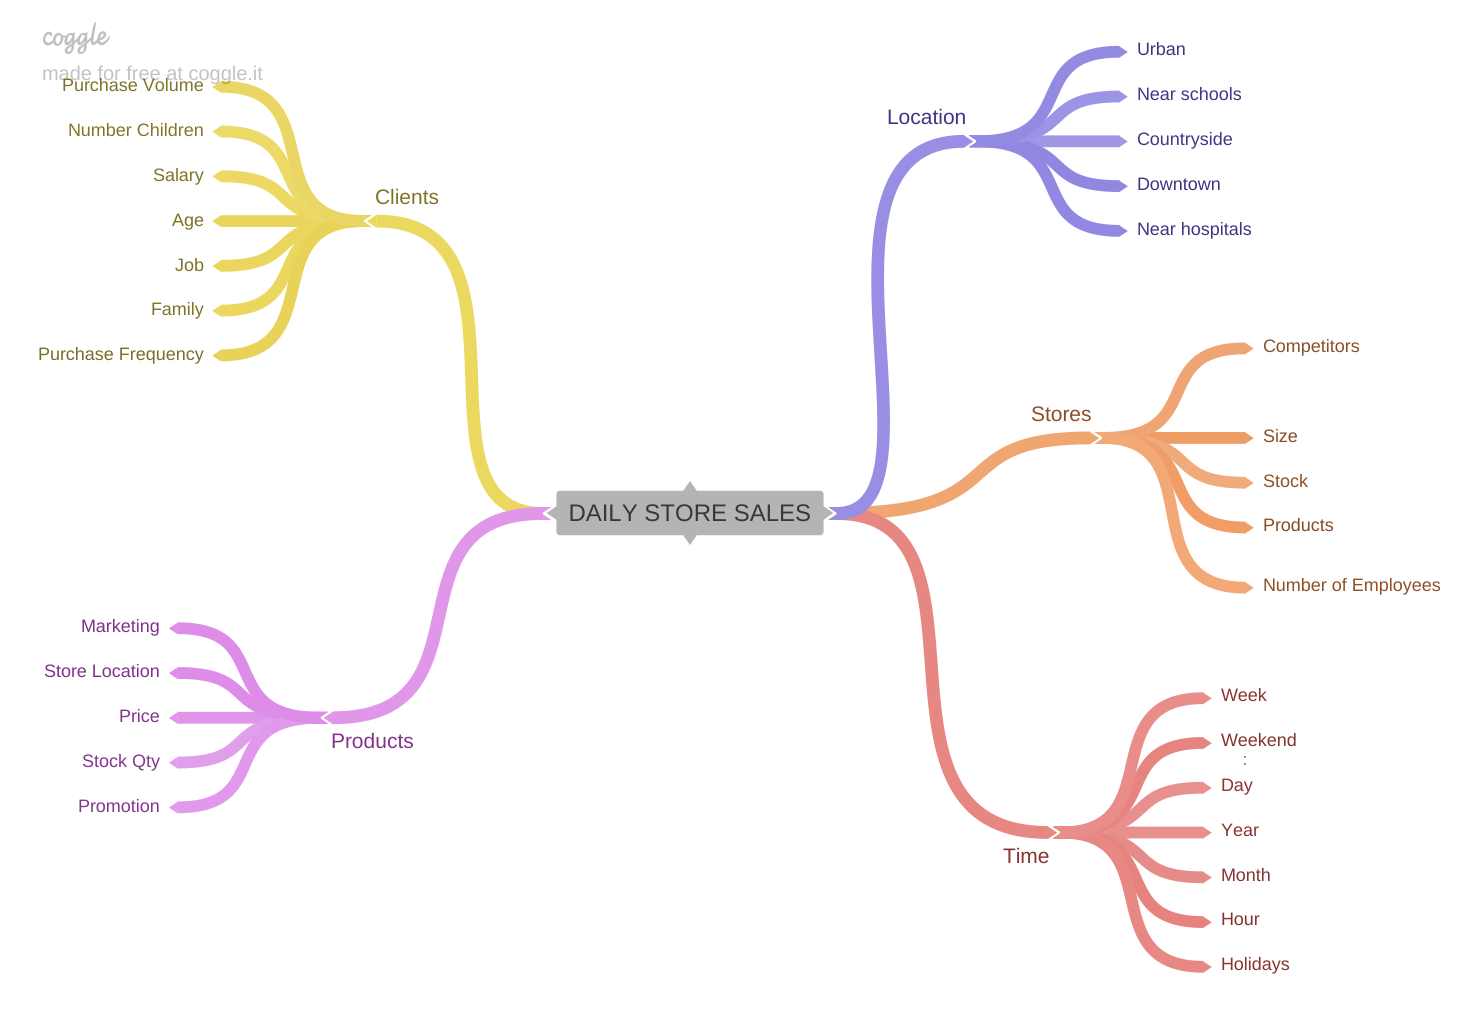

In [28]:
Image( 'img/MindMapHypotesis.png')

### 2.1.1 Hypothesis related to store

**1.** Stores with more employess, sell more

**2.** Stores with more stock probably, sell more

**3.** Stores with larger space, sell more

**4.** Stores with small space, sell less

**5.** Stores with more products available, sell more

**6.** Stores with more competition nearby sell less

**7.** Stores with competition for a longer time sell more

### 2.1.2 Hypothesis related to product

**1.** Stores with higher investment in Marketing, sell more

**2.** Stores with a better product disposition, probably sell more

**3.** Stores with cheaper prices, are more likely to sell more

**4.** Stores with active promotions for a longer period sell more

**5.** Stores with more days of promotions sell more

**6.** Stores with more promotion in a row sell morective promotions for a longer period sell more

### 2.1.3 Hypothesis related to Period

**1.** Stores open during Christmas sell more

**2.** Stores are more likely to sell more as years go by

**3.** Stores are more likely to improve sales in second semester

**4.** Stores sell more after day 10 of each month

**5.** Stores have a better selling result in weekends

**6.** Stores face a decrease on sales during school holidays

## 2.2 Final Hypothesis List

Based on the data we have right now, we select tbe hypothesis that can be answered.

**1.** Stores with more products available, sell more

**2.** Stores with more competition nearby sell less

**3.** Stores with competition for a longer time sell more


**4.** Stores with active promotions for a longer period sell more

**5.** Stores with more days of promotions sell more

**6.** Stores with more promotion in a row sell morective promotions for a longer period sell more

**7.** Stores open during Christmas sell more

**8.** Stores are more likely to sell more as years go by

**9.** Stores are more likely to improve sales in second semester

**10.** Stores sell more after day 10 of each month

**11.** Stores have a better selling result in weekends

**12.** Stores face a decrease on sales during school holidays


## 2.3 Feature Engineering

In [32]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year= x['competition_open_since_year'], month= x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/ 30).apply( lambda x: x.days ).astype(int)

# promo since



# assortment
# state holiday

In [34]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
